# Import the datasets

Datasets collected from Steam (https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data)

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz', 'steam_reviews.json.gz')
urllib.request.urlretrieve('https://cseweb.ucsd.edu/~wckang/steam_games.json.gz', 'steam_games.json.gz')

('steam_games.json.gz', <http.client.HTTPMessage at 0x7a3869d42c50>)

In [ ]:
!pip install dask

# Decompress the gzip files

In [ ]:
import gzip
import shutil

with gzip.open('steam_games.json.gz', 'rb') as infile:
    with open('steam_games.json', 'wb') as outfile:
        shutil.copyfileobj(infile, outfile)

with gzip.open('steam_reviews.json.gz', 'rb') as infile:
    with open('steam_reviews.json', 'wb') as outfile:
        shutil.copyfileobj(infile, outfile)

# Convert Python dict strings into valid JSON strings

In [ ]:
import ast
import json

with open('steam_games.json', 'r') as infile, open('steam_games_clean.json', 'w') as outfile:
    for line in infile:
        py_dict = ast.literal_eval(line.strip())
        json_line = json.dumps(py_dict)
        outfile.write(json_line + '\n')

with open('steam_reviews.json', 'r') as infile, open('steam_reviews_clean.json', 'w') as outfile:
    for line in infile:
        py_dict = ast.literal_eval(line.strip())
        json_line = json.dumps(py_dict)
        outfile.write(json_line + '\n')

# Clean, filter and merge the datasets

In [ ]:
import dask
from dask import dataframe as df
from dask import bag as db
import pandas as pd
import json

games_df = df.read_json('steam_games_clean.json')


expected_rev_cols = [
    'username', 'hours', 'products', 'product_id', 'page_order',
    'date', 'text', 'early_access', 'page', 'found_funny',
    'compensation', 'user_id'
]

reviews_meta = {
    'username': 'object',
    'hours': 'float64',
    'products': 'float64',
    'product_id': 'int64',
    'page_order': 'int64',
    'date': 'datetime64[ns]',
    'text': 'object',
    'early_access': 'bool',
    'page': 'int64',
    'found_funny': 'float64',
    'compensation': 'object',
    'user_id': 'float64'
}

reviews_bag = db.read_text('steam_reviews_clean.json', blocksize = '32MB')
reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


games_df = games_df[['id', 'app_name', 'tags', 'release_date']]
games_df['release_date'] = df.to_datetime(games_df['release_date'], errors='coerce')
games_df = games_df.dropna(subset=['release_date'])
games_df = games_df.dropna(subset=['tags'])
games_df = games_df.rename(columns={'id': 'product_id'})

def normalize_tags(tags):
    if tags is None or pd.isna(tags):
        return []
    if isinstance(tags, str):
        try:
            tags = ast.literal_eval(tags)
        except:
            return []
    return list(set(tag.strip().lower() for tag in tags if isinstance(tag, str)))

games_df['tags'] = games_df['tags'].map(normalize_tags, meta = ('tags', 'object'))
reviews_df = reviews_df[['product_id', 'hours']]
reviews_df['product_id'] = reviews_df['product_id'].astype('float64')

merged_data = games_df.merge(reviews_df, on='product_id', how='left')

<ipython-input-76-086da15cd2dd>:32: FutureWarning: from_legacy_dataframe is deprecated and will be removed in a future release. The legacy implementation as a whole is deprecated and will be removed, making this method unnecessary.
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


# Aggregate and filter combined data

In [ ]:
combined_data = merged_data.groupby('product_id').agg({
    'hours': 'sum',
    'app_name': 'first',
    'tags': 'first',
    'release_date': 'first',
    'product_id': 'count'
}).rename(columns={
    'hours': 'total_hours',
    'product_id': 'num_reviews'
}).reset_index()
combined = combined_data[combined_data['total_hours'] > 0]

# Define high engagement threshold & create subset of popular games based on threshold

In [ ]:
hours_threshold = combined['total_hours'].quantile(0.75)
reviews_threshold = combined['num_reviews'].quantile(0.75)
popular_df = combined[combined['total_hours'] >= hours_threshold]
popular_df = popular_df[popular_df['num_reviews'] >= reviews_threshold]

# Define recent games threshold & create subset of recent games based on threshold

In [ ]:
latest_date = combined['release_date'].max().compute()
recent_threshold = latest_date - pd.DateOffset(years=2)
recent_games_df = combined[combined['release_date'] >= recent_threshold]

# Apply A-Priori algorithm to the high engagement data

In [ ]:
!pip install mlxtend

In [ ]:
import mlxtend.preprocessing
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
popular = popular_df.compute()
tag_lists = popular['tags'].tolist()
encoded_array = (te.fit(tag_lists).transform(tag_lists))
encoded_data = pd.DataFrame(encoded_array, columns=te.columns_)

In [ ]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(encoded_data, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] > 1]
top_5_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(5)
frequent_itemsets = frequent_itemsets.drop(columns=['length', 'support'])
print(top_5_frequent_itemsets)

     support                   itemsets  length
24  0.486735     (singleplayer, action)       2
31  0.459524  (adventure, singleplayer)       2
37  0.421088      (singleplayer, indie)       2
16  0.393537        (adventure, action)       2
21  0.365306      (multiplayer, action)       2


# Apply Jaccard similarity to binary set of tags in recent games data and identified frequent itemsets

In [ ]:
frequent_sets = frequent_itemsets['itemsets'].apply(set).tolist()

def compute_jaccard_similarity(tags, frequent_sets):
    if not tags:
        return 0.0
    tag_set = set(tags)
    sims = []
    for fs in frequent_sets:
        union_len = len(tag_set | fs)
        if union_len > 0:
            sims.append(len(tag_set & fs) / union_len)
    return max(sims) if sims else 0.0

def apply_jaccard(partition, frequent_sets):
    partition = partition.copy()
    partition['jaccard_similarity'] = partition['tags'].apply(
        lambda tags: compute_jaccard_similarity(tags, frequent_sets)
    )
    return partition

games_with_similarity = recent_games_df.map_partitions(
    apply_jaccard,
    frequent_sets=frequent_sets,
    meta=(recent_games_df._meta.assign(jaccard_similarity='f8'))
)

result_df = games_with_similarity.compute()

# Create subset of exact tag combination matches in recent games to popular games & print

In [ ]:
exact_match = result_df[result_df['jaccard_similarity'] == 1.0]
print(exact_match[['product_id', 'app_name', 'tags']])

    product_id                                app_name  \
1     691810.0                        The Last Mission   
13    725500.0                    Pereulok: The Series   
23    747820.0     Terra Tanks: Defenders of the Earth   
22    765390.0                            The Darkness   
22    749470.0  TAOTH - The Adventures of the Herkulez   
31    685130.0                           Radar Defense   
36    713840.0                            Goblin Storm   
22    509920.0                          Doc Apocalypse   
26    736430.0                      Clicker bAdventure   
1     764470.0                               Gear Path   
0     753100.0                              Orbitality   
29    768060.0                The Warrior Of Treasures   
12    724980.0                          Winter Warland   
29    755610.0                    Defend Your Buttress   

                          tags  
1   [indie, adventure, action]  
13          [adventure, indie]  
23             [indie, action]

# Scalability on a single processor

<ipython-input-106-9cc357f55d7f>:41: FutureWarning: from_legacy_dataframe is deprecated and will be removed in a future release. The legacy implementation as a whole is deprecated and will be removed, making this method unnecessary.
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


     support                   itemsets  length
24  0.486735     (singleplayer, action)       2
31  0.459524  (adventure, singleplayer)       2
37  0.421088      (singleplayer, indie)       2
16  0.393537        (adventure, action)       2
21  0.365306      (multiplayer, action)       2
                                  app_name                        tags
1                         The Last Mission  [indie, adventure, action]
13                    Pereulok: The Series          [adventure, indie]
23     Terra Tanks: Defenders of the Earth             [indie, action]
22                            The Darkness  [action, adventure, indie]
22  TAOTH - The Adventures of the Herkulez             [indie, action]
31                           Radar Defense           [indie, strategy]
36                            Goblin Storm           [strategy, indie]
22                          Doc Apocalypse          [adventure, indie]
26                      Clicker bAdventure  [action, adventure, indie]
1 

<ipython-input-106-9cc357f55d7f>:41: FutureWarning: from_legacy_dataframe is deprecated and will be removed in a future release. The legacy implementation as a whole is deprecated and will be removed, making this method unnecessary.
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


     support                   itemsets  length
24  0.486735     (singleplayer, action)       2
31  0.459524  (adventure, singleplayer)       2
37  0.421088      (singleplayer, indie)       2
16  0.393537        (adventure, action)       2
21  0.365306      (multiplayer, action)       2
                                  app_name                        tags
1                         The Last Mission  [indie, adventure, action]
13                    Pereulok: The Series          [adventure, indie]
23     Terra Tanks: Defenders of the Earth             [indie, action]
22                            The Darkness  [action, adventure, indie]
22  TAOTH - The Adventures of the Herkulez             [indie, action]
31                           Radar Defense           [indie, strategy]
36                            Goblin Storm           [strategy, indie]
22                          Doc Apocalypse          [adventure, indie]
26                      Clicker bAdventure  [action, adventure, indie]
1 

<ipython-input-106-9cc357f55d7f>:41: FutureWarning: from_legacy_dataframe is deprecated and will be removed in a future release. The legacy implementation as a whole is deprecated and will be removed, making this method unnecessary.
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


     support                   itemsets  length
24  0.486735     (singleplayer, action)       2
31  0.459524  (adventure, singleplayer)       2
37  0.421088      (singleplayer, indie)       2
16  0.393537        (adventure, action)       2
21  0.365306      (multiplayer, action)       2
                                  app_name                        tags
1                         The Last Mission  [indie, adventure, action]
13                    Pereulok: The Series          [adventure, indie]
23     Terra Tanks: Defenders of the Earth             [indie, action]
22                            The Darkness  [action, adventure, indie]
22  TAOTH - The Adventures of the Herkulez             [indie, action]
31                           Radar Defense           [indie, strategy]
36                            Goblin Storm           [strategy, indie]
22                          Doc Apocalypse          [adventure, indie]
26                      Clicker bAdventure  [action, adventure, indie]
1 

<ipython-input-106-9cc357f55d7f>:41: FutureWarning: from_legacy_dataframe is deprecated and will be removed in a future release. The legacy implementation as a whole is deprecated and will be removed, making this method unnecessary.
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


     support                   itemsets  length
24  0.486735     (singleplayer, action)       2
31  0.459524  (adventure, singleplayer)       2
37  0.421088      (singleplayer, indie)       2
16  0.393537        (adventure, action)       2
21  0.365306      (multiplayer, action)       2
                                  app_name                        tags
1                         The Last Mission  [indie, adventure, action]
13                    Pereulok: The Series          [adventure, indie]
23     Terra Tanks: Defenders of the Earth             [indie, action]
22                            The Darkness  [action, adventure, indie]
22  TAOTH - The Adventures of the Herkulez             [indie, action]
31                           Radar Defense           [indie, strategy]
36                            Goblin Storm           [strategy, indie]
22                          Doc Apocalypse          [adventure, indie]
26                      Clicker bAdventure  [action, adventure, indie]
1 

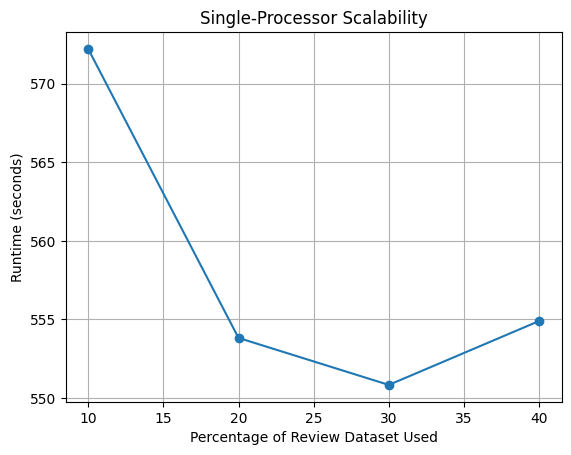

In [ ]:
import time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from dask import dataframe as df
from dask import bag as db
import pandas as pd
import json
import matplotlib.pyplot as plt

sizes = [0.1, 0.2, 0.3, 0.4]
times = []

for size in sizes:
  start = time.time()

  games_df = df.read_json('steam_games_clean.json')


  expected_rev_cols = [
      'username', 'hours', 'products', 'product_id', 'page_order',
      'date', 'text', 'early_access', 'page', 'found_funny',
      'compensation', 'user_id'
  ]

  reviews_meta = {
      'username': 'object',
      'hours': 'float64',
      'products': 'float64',
      'product_id': 'int64',
      'page_order': 'int64',
      'date': 'datetime64[ns]',
      'text': 'object',
      'early_access': 'bool',
      'page': 'int64',
      'found_funny': 'float64',
      'compensation': 'object',
      'user_id': 'float64'
  }

  reviews_bag = db.read_text('steam_reviews_clean.json', blocksize = '32MB')
  reviews_df = reviews_bag.map(json.loads).map(lambda x: {col: x.get(col) for col in expected_rev_cols}).to_dataframe(meta=reviews_meta)


  games_df = games_df[['id', 'app_name', 'tags', 'release_date']]
  games_df['release_date'] = df.to_datetime(games_df['release_date'], errors='coerce')
  games_df = games_df.dropna(subset=['release_date'])
  games_df = games_df.dropna(subset=['tags'])
  games_df = games_df.rename(columns={'id': 'product_id'})

  def normalize_tags(tags):
      if tags is None or pd.isna(tags):
          return []
      if isinstance(tags, str):
          try:
              tags = ast.literal_eval(tags)
          except:
              return []
      return list(set(tag.strip().lower() for tag in tags if isinstance(tag, str)))

  games_df['tags'] = games_df['tags'].map(normalize_tags, meta = ('tags', 'object'))
  reviews_df = reviews_df[['product_id', 'hours']]
  reviews_df['product_id'] = reviews_df['product_id'].astype('float64')

  merged_data = games_df.merge(reviews_df, on='product_id', how='left')

  combined_data = merged_data.groupby('product_id').agg({
      'hours': 'sum',
      'app_name': 'first',
      'tags': 'first',
      'release_date': 'first',
      'product_id': 'count'
  }).rename(columns={
      'hours': 'total_hours',
      'product_id': 'num_reviews'
  }).reset_index()
  combined = combined_data[combined_data['total_hours'] > 0]

  hours_threshold = combined['total_hours'].quantile(0.75)
  reviews_threshold = combined['num_reviews'].quantile(0.75)
  popular_df = combined[combined['total_hours'] >= hours_threshold]
  popular_df = popular_df[popular_df['num_reviews'] >= reviews_threshold]

  latest_date = combined['release_date'].max().compute()
  recent_threshold = latest_date - pd.DateOffset(years=2)
  recent_games_df = combined[combined['release_date'] >= recent_threshold]

  te = TransactionEncoder()
  popular = popular_df.compute()
  tag_lists = popular['tags'].tolist()
  encoded_array = (te.fit(tag_lists).transform(tag_lists))
  encoded_data = pd.DataFrame(encoded_array, columns=te.columns_)

  frequent_itemsets = apriori(encoded_data, min_support=0.2, use_colnames=True)
  frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
  frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] > 1]
  top_5_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(5)
  frequent_itemsets = frequent_itemsets.drop(columns=['length', 'support'])
  print(top_5_frequent_itemsets)

  frequent_sets = frequent_itemsets['itemsets'].apply(set).tolist()

  def compute_jaccard_similarity(tags, frequent_sets):
      if not tags:
          return 0.0
      tag_set = set(tags)
      sims = []
      for fs in frequent_sets:
          union_len = len(tag_set | fs)
          if union_len > 0:
              sims.append(len(tag_set & fs) / union_len)
      return max(sims) if sims else 0.0

  def apply_jaccard(partition, frequent_sets):
      partition = partition.copy()
      partition['jaccard_similarity'] = partition['tags'].apply(
          lambda tags: compute_jaccard_similarity(tags, frequent_sets)
      )
      return partition

  games_with_similarity = recent_games_df.map_partitions(
      apply_jaccard,
      frequent_sets=frequent_sets,
      meta=(recent_games_df._meta.assign(jaccard_similarity='f8'))
  )

  result_df = games_with_similarity.compute()

  exact_match = result_df[result_df['jaccard_similarity'] == 1.0]
  print(exact_match[['app_name', 'tags']])
  end = time.time()
  times.append(end - start)

plt.plot([int(size*100) for size in sizes], times, marker='o')
plt.xlabel("Percentage of Review Dataset Used")
plt.ylabel("Runtime (seconds)")
plt.title("Single Processor Scalability")
plt.grid(True)
plt.show()